In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
# Import libraries
import keras
import keras.backend as K
from keras.models import Model
# Activation and Regularization
from keras.regularizers import l2
from keras.activations import softmax
# Keras layers
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers import Dense, Dropout, Flatten, Input, BatchNormalization, Activation
from keras.layers.pooling import MaxPooling2D, AveragePooling2D

# Model architecture
from elu_resnet_2d_distances import *

# Loading the Dataset

In [2]:
def parse_lines(raw):
    return [[float(x) for x in line.split("\t") if x != ""] for line in raw]

def parse_line(line):
    return [float(x) for x in line.split("\t") if x != ""]

In [3]:
path = "../data/full_under_200.txt"
# Opn file and read text
with open(path, "r") as f:
    lines = f.read().split('\n')

In [4]:
# Scan first n proteins
names = []
seqs = []
dists = []
pssms = []

# Extract numeric data from text
for i,line in enumerate(lines):
    if len(names) == 111:
        break
    # Read each protein separately
    if line == "[ID]":
        names.append(lines[i+1])
    elif line == "[PRIMARY]":
        seqs.append(lines[i+1])
    elif line == "[EVOLUTIONARY]":
        pssms.append(parse_lines(lines[i+1:i+21]))
    elif line == "[DIST]":
        dists.append(parse_lines(lines[i+1:i+len(seqs[-1])+1]))
        # Progress control
        if len(names)%50 == 0:
            print("Currently @ ", len(names), " out of n (500)")

Currently @  50  out of n (500)
Currently @  100  out of n (500)


In [6]:
def wider(seq, l=200, n=20):
    """ Converts a seq into a one-hot tensor. Not LxN but LxLxN"""
    key = "HRKDENQSYTCPAVLIGFWM"
    tensor = []
    for i in range(l):
        d2 = []
        for j in range(l):
            d1 = [1 if (j<len(seq) and i<len(seq) and key[x] == seq[i] and key[x] == seq[j]) else 0 for x in range(n)]
    
            d2.append(d1)
        tensor.append(d2)
    
    return np.array(tensor)

In [7]:
inputs_aa = np.array([wider(seq) for seq in seqs])

In [8]:
inputs_aa.shape

(110, 200, 200, 20)

In [9]:
def wider_pssm(pssm, seq, l=200, n=20):
    """ Converts a seq into a one-hot tensor. Not LxN but LxLxN"""
    key = "HRKDENQSYTCPAVLIGFWM"
    key_alpha = "ACDEFGHIKLMNPQRSTVWY"
    tensor = []
    for i in range(l):
        d2 = []
        for j in range(l):
            if (i==j and j<len(seq) and i<len(seq)):
                d1 = [aa[i] for aa in pssm]
            else:
                d1 = [0 for i in range(n)]
                
            # Append pssm[i]*pssm[j]
            if j<len(seq) and i<len(seq):
                d1.append(pssm[key_alpha.index(seq[i])][i] *
                          pssm[key_alpha.index(seq[j])][j])
            else: 
                d1.append(0)
            # Append custom distance to diagonal
            d1.append(1 - abs(i-j)/200)
    
            d2.append(d1)
        tensor.append(d2)
    
    return np.array(tensor)

In [10]:
inputs_pssm = np.array([wider_pssm(pssms[i], seqs[i]) for i in range(len(pssms))])

In [11]:
inputs_pssm.shape

(110, 200, 200, 22)

In [12]:
inputs = np.concatenate((inputs_aa, inputs_pssm), axis=3)
inputs.shape
# Delete unnecessary data
del inputs_pssm #  = inputs_pssm[:10]
del inputs_aa #  = inputs_aa[:10]

In [13]:
# Embed number of rows
def embedding_matrix(matrix, l=200):
    # Embed with extra columns
    for i in range(len(matrix)):
        while len(matrix[i])<l:
            matrix[i].extend([-1 for i in range(l-len(matrix[i]))])
    #Embed with extra rows
    while len(matrix)<l:
        matrix.append([-1 for x in range(l)])
    return np.array(matrix)

In [14]:
dists = np.array([embedding_matrix(matrix) for matrix in dists])

In [15]:
def treshold(matrix, cuts=[-0.5, 500, 750, 1000, 1400, 1700, 2000], l=200):
    # Turns an L*L*1 tensor into an L*L*N 
    trash = (np.array(matrix)<cuts[0]).astype(np.int)
    first = (np.array(matrix)<cuts[1]).astype(np.int)-trash
    sec = (np.array(matrix)<cuts[2]).astype(np.int)-trash-first
    third = (np.array(matrix)<=cuts[3]).astype(np.int)-trash-first-sec
    fourth = (np.array(matrix)<=cuts[4]).astype(np.int)-trash-first-sec-third
    fifth = (np.array(matrix)<=cuts[5]).astype(np.int)-trash-first-sec-third-fourth
    sixth = np.array(matrix)>cuts[5]
    
    return np.concatenate((trash.reshape(l,l,1),
                           first.reshape(l,l,1),
                           sec.reshape(l,l,1),
                           third.reshape(l,l,1),
                           fourth.reshape(l,l,1),
                           fifth.reshape(l,l,1),
                           sixth.reshape(l,l,1)),axis=2)

In [16]:
outputs = np.array([treshold(d) for d in dists])

In [17]:
print(outputs.shape)
del dists

(110, 200, 200, 7)


# Loading the model

In [19]:
kernel_size, filters = 3, 16
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)

In [25]:
# Using AMSGrad optimizer for speed 
kernel_size, filters = 3, 16
adam = keras.optimizers.Adam(amsgrad=True)
# Create model
model = resnet_v2(input_shape=(200,200, 42), depth=28, num_classes=7)

In [26]:
model.compile(optimizer=adam, loss=weighted_categorical_crossentropy(np.array([1e-07, 0.45, 1.65, 1.75, 0.73, 0.77, 0.145])), metrics=["accuracy"])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 200, 200, 42) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 200, 200, 64) 24256       input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 200, 200, 64) 256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 200, 200, 64) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
batch_norm

## Model training

In [27]:
his = model.fit(inputs, outputs, epochs=35, batch_size=2, verbose=1, shuffle=True, validation_split=0.1)
print(his.history)

Train on 99 samples, validate on 11 samples
Epoch 1/35
99/99 [==============================] - 42s 422ms/step - loss: 0.9372 - acc: 0.1321 - val_loss: 0.7920 - val_acc: 0.1255
Epoch 2/35
99/99 [==============================] - 20s 206ms/step - loss: 0.7442 - acc: 0.1463 - val_loss: 0.7027 - val_acc: 0.1354
Epoch 3/35
99/99 [==============================] - 20s 206ms/step - loss: 0.6821 - acc: 0.1499 - val_loss: 0.6352 - val_acc: 0.1485
Epoch 4/35
99/99 [==============================] - 20s 207ms/step - loss: 0.6288 - acc: 0.1606 - val_loss: 0.5819 - val_acc: 0.1551
Epoch 5/35
99/99 [==============================] - 21s 208ms/step - loss: 0.5838 - acc: 0.1606 - val_loss: 0.5378 - val_acc: 0.1618
Epoch 6/35
99/99 [==============================] - 20s 207ms/step - loss: 0.5426 - acc: 0.1600 - val_loss: 0.5048 - val_acc: 0.1485
Epoch 7/35
99/99 [==============================] - 21s 207ms/step - loss: 0.5101 - acc: 0.1514 - val_loss: 0.4718 - val_acc: 0.1635
Epoch 8/35
99/99 [=======

In [38]:
model.save("tester_28.h5")

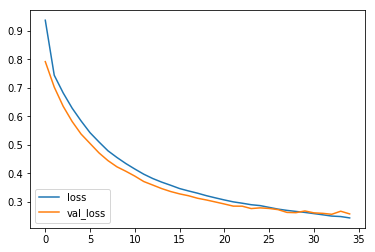

In [28]:
plt.figure()

plt.plot(his.history["loss"])
plt.plot(his.history["val_loss"])
plt.legend(["loss", "val_loss"], loc="lower left")
plt.show()

## Check the model has learned something

In [29]:
i,k = 0, 5
sample_pred = model.predict([inputs[i:i+k]])

In [30]:
preds4 = np.argmax(sample_pred, axis=3)
preds4[preds4==0] = 6 # Change trash class by class for long distance

In [31]:
outs4 = np.argmax(outputs[i:i+k], axis=3)
outs4[outs4==0] = 6 # Change trash class by class for long distance

In [32]:
# Select the best prediction to display it - (proportional by protein length(area of contact map))
results = [np.sum(np.equal(pred[:len(seqs[i+j]), :len(seqs[i+j])], outs4[j, :len(seqs[i+j]), :len(seqs[i+j]),]),axis=(0,1))/
           len(seqs[i+j])**2 
           for j,pred in enumerate(preds4)]
best_score = max(results)
print("Best score (Accuracy): ", best_score)
sorted_scores = [acc for acc in sorted(results, key=lambda x: x, reverse=True)]
print("Best 5 scores: ", sorted_scores[:5])
print("Best 5 indices: ", [results.index(x) for x in sorted_scores[:5]])
best_score_index = results.index(best_score)
print("Index of best score: ", best_score_index)    

Best score (Accuracy):  0.5191195416792302
Best 5 scores:  [0.5191195416792302, 0.45942015387502344, 0.4441293845830708, 0.42058298631766805, 0.39982222222222225]
Best 5 indices:  [0, 1, 4, 2, 3]
Index of best score:  0


In [33]:
# best_score_index = results.index(0.6597390187822867)
# print(best_score_index)
best_score_index = 3
i=0

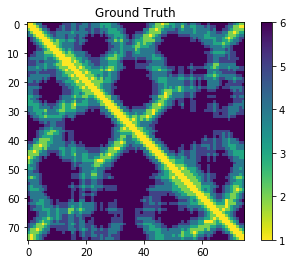

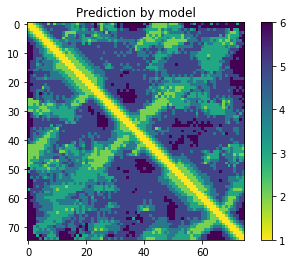

In [34]:
plt.title('Ground Truth')
plt.imshow(outs4[best_score_index, :len(seqs[i+best_score_index]), :len(seqs[i+best_score_index])],
           cmap='viridis_r', interpolation='nearest')
plt.colorbar()
plt.show()

# Then plot predictions by the model - v2
plt.title("Prediction by model")
plt.imshow(preds4[best_score_index, :len(seqs[i+best_score_index]), :len(seqs[i+best_score_index])],
           cmap='viridis_r', interpolation='nearest')
plt.colorbar()
plt.show()

In [43]:
# model.save("elu_resnet_2d_distance_valacc_0_59_acc.h5")

In [35]:
# Done!
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

In [36]:
preds_crop = np.concatenate( [pred[:len(seqs[i+j]), :len(seqs[i+j])].flatten() for j,pred in enumerate(preds4)] )
outs_crop = np.concatenate( [outs4[j, :len(seqs[i+j]), :len(seqs[i+j])].flatten() for j,pred in enumerate(preds4)] )

Normalized confusion matrix
Introducing total mse:  386.3405233728401
Introducing mse/prot:  77.26810467456802


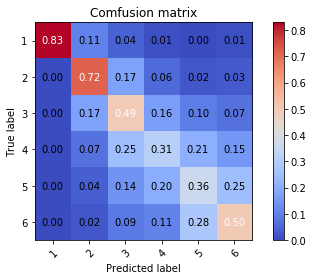

In [37]:
matrix = cm = confusion_matrix(outs_crop, preds_crop)

classes = [i+1 for i in range(7)]
title = "Comfusion matrix"
cmap = "coolwarm"
normalize = True

if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
else:
    print('Confusion matrix, without normalization')

# print(cm)

fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
ax.figure.colorbar(im, ax=ax)
# We want to show all ticks...
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       # ... and label them with the respective list entries
       xticklabels=classes, yticklabels=classes,
       title=title,
       ylabel='True label',
       xlabel='Predicted label')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
fmt = '.2f' if normalize else 'd'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
fig.tight_layout()

print("Introducing total mse: ", np.linalg.norm(outs_crop-preds_crop))
print("Introducing mse/prot: ", np.linalg.norm(outs_crop-preds_crop)/len(preds4))

## Done! Let's continue training the model with the whole data!